# Why Jupyter notebooks

### Jupyter notebooks allow us to interactively run code. We can execute portions of the code that we want without having to run everything. When the last line of a cell is an object, Jupyter will print it out neatly.

# Benefits of running in a docker container:

### Will always get the same notebooks regardless of what you change when running

### Easily able to put hard and soft caps on resources

### Deployable in the cloud and across any machine with docker

### Keeps a stable version that can be pulled as a docker image

### Can run image in background and use it for similar purposes as "screen"

### Docker containers can be setup to restart when they are stopped, so you could make the container start on bootup.

### General docker reasons

# 2.0 Numpy, Dask, Xarray, and Zarr

## 2.1 Numpy

Note: you can use numpy arrays, but it will push limits of machine

### Numpy is library that makes analytical computations fast and easy. It provides broadcasted arrays, utility functions, and more.

In [1]:
import numpy as np
y = np.array([1, 2, 3, 4, 5])
y = y + 5
y

array([ 6,  7,  8,  9, 10])

### Note the difference between a numpy array and a python list. Numpy will usually convert python lists to arrays.

In [2]:
np.append([1,2,3], [4,5])

array([1, 2, 3, 4, 5])

In [3]:
y = y.sum()
y

40

## 2.2 Dask

### Dask is a library that enables parallel computing. It tries to mimic the API of numpy. When using dask, data is not computed right away. You can do operations and it will plan out what it needs to do once data is computed (using a digraph).

In [4]:
from dask import array as da
y = da.array([1, 2, 3, 4, 5])
y = y + 5
y

dask.array<add, shape=(5,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

### Notice that when we try to sum it, it still is not computed.

In [5]:
y = y.sum()
y

dask.array<sum-aggregate, shape=(), dtype=int64, chunksize=(), chunktype=numpy.ndarray>

### To compute the data, we can use da.compute(). Dask arrays will also be computed by functions that require resolved data, such as plotting. Computations will not compute Dask arrays into memory.

In [6]:
y.compute()

40

In [7]:
da.compute(y, y, y)

(40, 40, 40)

### The cool part, is that dask arrays can be split up into chunks along each dimension.
### Why is this useful?
1. It allows us to opperate on datasets that are normally too large to fit into memory
2. It breaks the computations into small pieces that can then be completed simultaneously

### How to think about chunks: Imagine a tiny square. Now imagine your computer's memory as 4 of those tiny squares. The data we are trying to compute is made up of hundreds of those tiny squares with the information we want located in certain squares. To get the information we need, we would take 4 squares at a time until everything was processed. The tricky part is finding the most efficient way to get only what you need.

## 2.3 Xarray

### Xarray is a library that simplifies working with multidimensional arrays. It uses Dask and Numpy in the backend. If you are familiar with NETCDF4 format, xarray is a virtualization of that. The two objects we are concerned with are DataArrays (Same idea as dask and numpy) and Datasets (same idea as the Pandas library)

make note of how datasets are tabular objects

In [159]:
import xarray as xr
dataarray = xr.DataArray([1, 2, 3])
dataarray.attrs['a'] = 'yes'
dataarray

<xarray.DataArray (dim_0: 3)>
array([1, 2, 3])
Dimensions without coordinates: dim_0
Attributes:
    a:        yes

In [9]:
dataset = xr.Dataset({'a': [1, 2, 3], 'b': 108})
dataset

<xarray.Dataset>
Dimensions:  (a: 3)
Coordinates:
  * a        (a) int64 1 2 3
Data variables:
    b        int64 108

### We can access the variables the same way we access dictionary objects in python

In [160]:
dataset['a']

<xarray.DataArray 'a' (a: 3)>
array([1, 2, 3])
Coordinates:
  * a        (a) int64 1 2 3

### Since Dask and Numpy arrays are being used under the hood, we can access them using the data attribute

In [163]:
dataset['a'].data

array([1, 2, 3])

### In general Xarray is great for higher level analyses since it has metadeta. It's usually better to do heavy computation with the underlying arrays

# 2.4 Zarr

### Zarr is a format for the storage of chunked, compressed, N-dimensional arrays

In [164]:
%rm -rf test
import zarr as zr
z1 = zr.open('test/example.zarr', mode='w', shape=(10000, 10000), chunks=(1000, 1000), dtype=float)
z1[:] = 42
z1[0, :] = np.arange(10000)
z1[:, 0] = np.arange(10000)

### Try to load the data using xarray

In [165]:
xr.open_zarr('test')

GroupNotFoundError: group not found at path ''

### Xarray currently needs 2 additional things to open a zarr array not written by Zarr

### _ARRAY_DIMENSIONS tell xarray what the names of the dimensions are

In [167]:
z1.attrs.setdefault('_ARRAY_DIMENSIONS', ["dim1", "dim2"])

['dim1', 'dim2']

### .zgroup tells xarray which zarr format to use

In [169]:
with open("test/.zgroup", "w") as file:
    file.write("\n".join(['{', '    "zarr_format": 2', '}']))

In [191]:
xr.open_zarr('test')

<xarray.Dataset>
Dimensions:       (dim1: 10000, dim2: 10000)
Dimensions without coordinates: dim1, dim2
Data variables:
    example.zarr  (dim1, dim2) float64 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

# 3.0 Cris Survey API

In [172]:
from cris_survey_api import Survey

### Call the Survey object and it will pull the data from disk. It defaults to L1B NOAA20 FSR of the most recent version (currently 3.0.1). The chunks keyword arguments tells the code to compute 40 days worth of data in memory at once when doing computations

In [173]:
%%time
# Survey(product=None, instrument=None, resolution=None, version=None)
cris_l1b_noaa20_fsr_survey = Survey(chunks={'day': 40})

CPU times: user 394 ms, sys: 133 ms, total: 527 ms
Wall time: 4.81 s


### Access the data

In [194]:
# get_xarray(*variables, day=None, granule=None, atrack=None, xtrack=None, fov=None, exclude=None)
survey = cris_l1b_noaa20_fsr_survey.get_xarray()
survey['lon'].data[survey['lat'].data < 50]

dask.array<getitem, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [195]:
survey

<xarray.Dataset>
Dimensions:                                           (atrack: 45, attitude: 3, day: 10957, fov: 9, granule: 240, spatial: 3, utc_tuple: 8, xtrack: 30)
Dimensions without coordinates: atrack, attitude, day, fov, granule, spatial, utc_tuple, xtrack
Data variables:
    AutomaticQualityFlag                              (day, granule) int8 dask.array<chunksize=(40, 240), meta=np.ndarray>
    asc_flag                                          (day, granule, atrack) float32 dask.array<chunksize=(40, 240, 45), meta=np.ndarray>
    bt_lw_wnum900                                     (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    bt_mw_wnum1600                                    (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    bt_sw_wnum2500                                    (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:es_igm_spike_detect               (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:es_igm_spike_detect:total         (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:ict_igm_outlier                   (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:ict_igm_outlier:total             (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:imag_rad_anomaly                  (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:imag_rad_anomaly:total            (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:l1a_missing_es                    (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:l1a_missing_es:total              (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:lunar_intrusion                   (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:lunar_intrusion:total             (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:quality_degraded                  (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:quality_degraded:total            (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:quality_invalid                   (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:quality_invalid:total             (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:rad_cal_qual_degraded             (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:rad_cal_qual_degraded:total       (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:rad_cal_qual_invalid              (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:rad_cal_qual_invalid:total        (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:spectral_cal_qual_degraded        (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), meta=np.ndarray>
    cal_lw_qualflag:spectral_cal_qual_degraded:total  (day, granule) float64 dask.array<chunksize=(40, 240), meta=np.ndarray>
    cal_lw_qualflag:spectral_cal_qual_invalid         (day, granule, atrack, xtrack, fov) float32 dask.array<chunksize=(40, 240, 45, 30, 9), met

### Lets only look at only lat and lon

In [175]:
dataframe = cris_l1b_noaa20_fsr_survey.get_xarray('lat', 'lon')
dataframe

,Array,Chunk
Bytes,127.80 GB,466.56 MB
Shape,"(10957, 240, 45, 30, 9)","(40, 240, 45, 30, 9)"
Count,275 Tasks,274 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,127.80 GB,466.56 MB
Shape,"(10957, 240, 45, 30, 9)","(40, 240, 45, 30, 9)"
Count,275 Tasks,274 Chunks
Type,float32,numpy.ndarray


### To get each variable split out, we can do the following

In [176]:
lat = dataframe['lat']
lon = dataframe['lon']
lat

,Array,Chunk
Bytes,127.80 GB,466.56 MB
Shape,"(10957, 240, 45, 30, 9)","(40, 240, 45, 30, 9)"
Count,275 Tasks,274 Chunks
Type,float32,numpy.ndarray


### And to get the underlying array

In [19]:
lat.data

,Array,Chunk
Bytes,127.80 GB,466.56 MB
Shape,"(10957, 240, 45, 30, 9)","(40, 240, 45, 30, 9)"
Count,275 Tasks,274 Chunks
Type,float32,numpy.ndarray


### The survey API provides a utility function that does this work for you!

In [20]:
lat, lon = cris_l1b_noaa20_fsr_survey.get_dask('lat', 'lon')
lat

,Array,Chunk
Bytes,127.80 GB,466.56 MB
Shape,"(10957, 240, 45, 30, 9)","(40, 240, 45, 30, 9)"
Count,275 Tasks,274 Chunks
Type,float32,numpy.ndarray


### Note: The survey days span from Jan 1st 2010 to Jan 1st 2040. Thus, the index of the days is the days since 2010.

# 4.0 Example: Plot spike detect time series

In [177]:
from cris_survey_api import Survey
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
from dask import array as da

In [178]:
survey = Survey(chunks={'day': 40})

### Get the data. For this example, Lets look at a full year starting in Summer 2019. In your example, you can leave out the days arguments, but it will take longer since it will have to look at the entire mission (2010 to 2040).

In [23]:
base_date = datetime(2010, 1, 1)
start_date = (datetime(2019, 6, 1) - base_date).days
end_date = (datetime(2020, 6, 1) - base_date).days
# Note that range is (min_inclusive, max_exclusive)
sw_fov_spikes, mw_fov_spikes, lw_fov_spikes = survey.get_dask('cal_sw_qualflag:es_igm_spike_detect',
                                                              'cal_mw_qualflag:es_igm_spike_detect',
                                                              'cal_lw_qualflag:es_igm_spike_detect',
                                                              day=range(start_date, end_date + 1))

### Sum all the spike detects to the day level. Since the axis format is day, granule, atrack, xtrack, fov, we sum along the 2nd, 3rd, 4th, and 5th axis. np.nansum will add all values and ignore nans (unknown fill values)

In [180]:
sw_daily_spikes = da.nansum(sw_fov_spikes, axis=(1,2,3,4))
mw_daily_spikes = da.nansum(mw_fov_spikes, axis=(1,2,3,4))
lw_daily_spikes = da.nansum(lw_fov_spikes, axis=(1,2,3,4))
sw_daily_spikes

dask.array<sum-aggregate, shape=(367,), dtype=float32, chunksize=(40,), chunktype=numpy.ndarray>

### Next, get all the indices where the spike detect is greater than 0

In [190]:
indices = np.argwhere((sw_daily_spikes + mw_daily_spikes + lw_daily_spikes) > 0)
indices

dask.array<getitem_variadic, shape=(nan, 1), dtype=int64, chunksize=(nan, 1), chunktype=numpy.ndarray>

### The indices are a list of 1-element indices at this point. We want it to be just a list of indices.

In [183]:
indices = indices.squeeze()
indices

dask.array<getitem, shape=(nan,), dtype=int64, chunksize=(nan,), chunktype=numpy.ndarray>

### Get the x and y values for plotting.

In [184]:
%%time
x, sw_y, mw_y, lw_y = da.compute(indices, sw_daily_spikes, mw_daily_spikes, lw_daily_spikes)
sw_y = sw_y[x]
mw_y = mw_y[x]
lw_y = lw_y[x]
x = x + start_date

CPU times: user 36.7 s, sys: 24.1 s, total: 1min
Wall time: 3.24 s


### Make a basic scatter plot

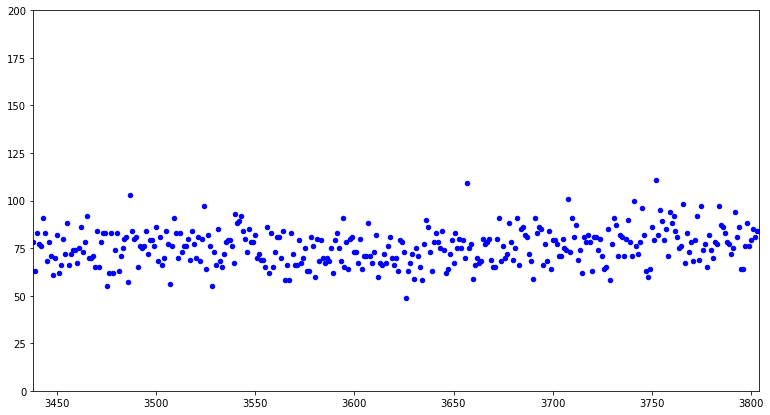

In [186]:
%matplotlib inline
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')
# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(13, 7))
# Plot x and sw_y with dots of size 20 and color blue.
ax.scatter(x, sw_y, color='blue', s=20)

# Set the y-axis from 0 to 200.
ax.set_ylim([0, 200])
ax.set_xlim([x[0], x[-1]])

fig.show()

### Add text

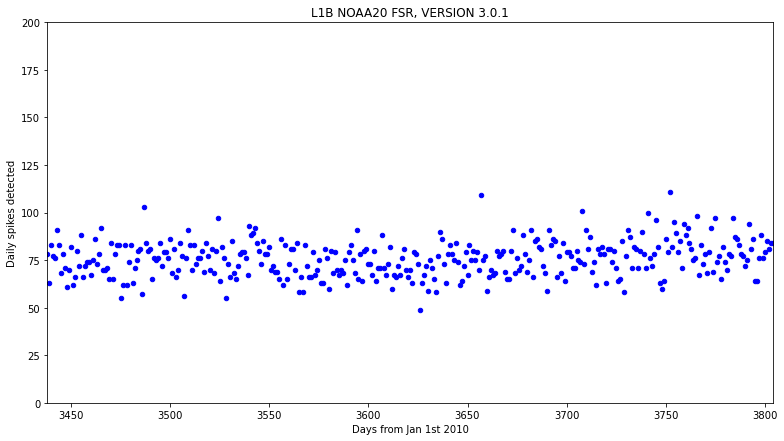

In [29]:
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')
# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(13, 7))
# Plot x and sw_y with dots of size 20 and color blue.
ax.scatter(x, sw_y, color='blue', s=20)

#################################################################
# Add the survey info to the title.
# put into abs strings
ax.set_title('{0} {1} {2}, VERSION {3}'.format(survey.product,
                                               survey.instrument,
                                               survey.resolution,
                                               survey.software_version))
ax.set_xlabel('Days from Jan 1st 2010')
ax.set_ylabel('Daily spikes detected')
#################################################################

ax.set_ylim([0, 200])
ax.set_xlim([x[0], x[-1]])

fig.show()

### Increase text size of all text

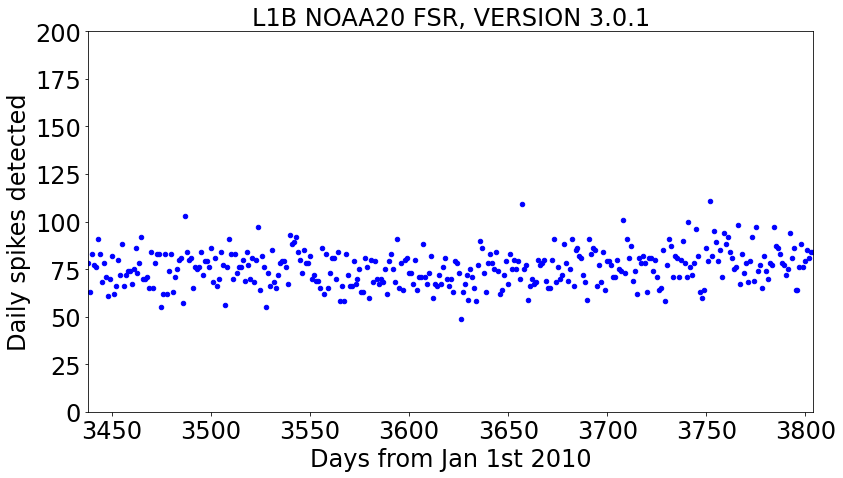

In [30]:
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')
# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(13, 7))
# Plot x and sw_y with dots of size 20 and color blue.
ax.scatter(x, sw_y, color='blue', s=20)

# Add the survey info to the title.
ax.set_title('{0} {1} {2}, VERSION {3}'.format(survey.product,
                                               survey.instrument,
                                               survey.resolution,
                                               survey.software_version))
ax.set_xlabel('Days from Jan 1st 2010')
ax.set_ylabel('Daily spikes detected')

#########################################################
text_objects = [ax.title, ax.xaxis.label, ax.yaxis.label]
text_objects.extend(ax.get_xticklabels())
text_objects.extend(ax.get_yticklabels())
for text_object in (text_objects):
    text_object.set_fontsize(24)
#########################################################

ax.set_ylim([0, 200])
ax.set_xlim([x[0], x[-1]])

fig.show()

### Add all three wave lengths

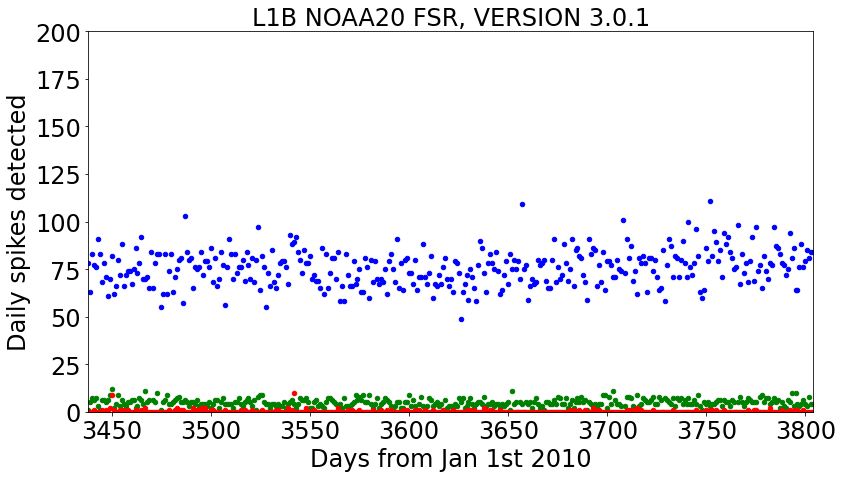

In [31]:
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')
# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(13, 7))
######################################################
# Plot all 3 x and y with dots of size 20.
for y, color in [(sw_y, 'blue'),
                 (mw_y, 'green'),
                 (lw_y, 'red')]:
    ax.scatter(x, y, color=color, s=20)
######################################################

# Add the survey info to the title.
ax.set_title('{0} {1} {2}, VERSION {3}'.format(survey.product,
                                               survey.instrument,
                                               survey.resolution,
                                               survey.software_version))
ax.set_xlabel('Days from Jan 1st 2010')
ax.set_ylabel('Daily spikes detected')

text_objects = [ax.title, ax.xaxis.label, ax.yaxis.label]
text_objects.extend(ax.get_xticklabels())
text_objects.extend(ax.get_yticklabels())
for text_object in (text_objects):
    text_object.set_fontsize(24)

ax.set_ylim([0, 200])
ax.set_xlim([x[0], x[-1]])

fig.show()

### Add a line of fit

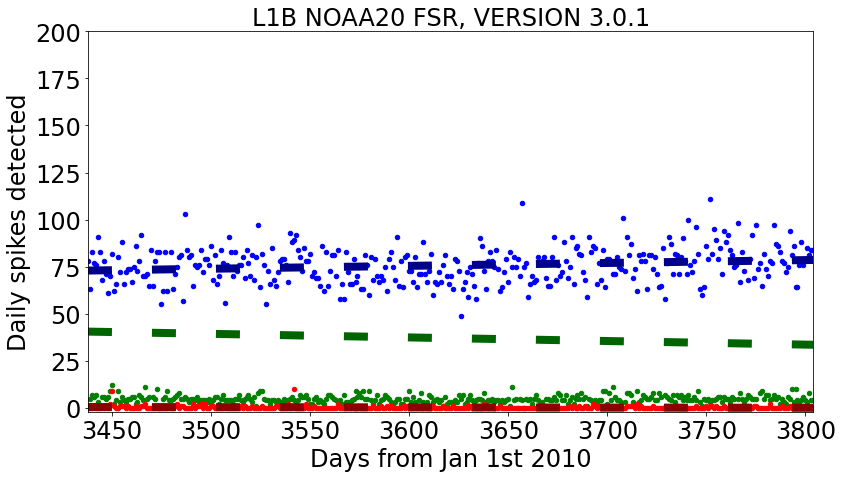

In [188]:
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')
# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(13, 7))
# Plot all 3 x and y with dots of size 20.
for y, color in [(sw_y, 'blue'),
                 (mw_y, 'green'),
                 (lw_y, 'red')]:
    ax.scatter(x, y, color=color, s=20)
    
    ###########################################
    m, b = np.polyfit(x, y, 1)
    plt.plot(x, m * x + b, '--', dashes=(3, 5),
             linewidth=8, color='dark' + color)
    ###########################################

# Add the survey info to the title.
ax.set_title('{0} {1} {2}, VERSION {3}'.format(survey.product,
                                               survey.instrument,
                                               survey.resolution,
                                               survey.software_version))
ax.set_xlabel('Days from Jan 1st 2010')
ax.set_ylabel('Daily spikes detected')

text_objects = [ax.title, ax.xaxis.label, ax.yaxis.label]
text_objects.extend(ax.get_xticklabels())
text_objects.extend(ax.get_yticklabels())
for text_object in (text_objects):
    text_object.set_fontsize(24)

ax.set_ylim([-2, 200])
ax.set_xlim([x[0], x[-1]])

fig.show()

### Format x-axis to use dates and add grid lines

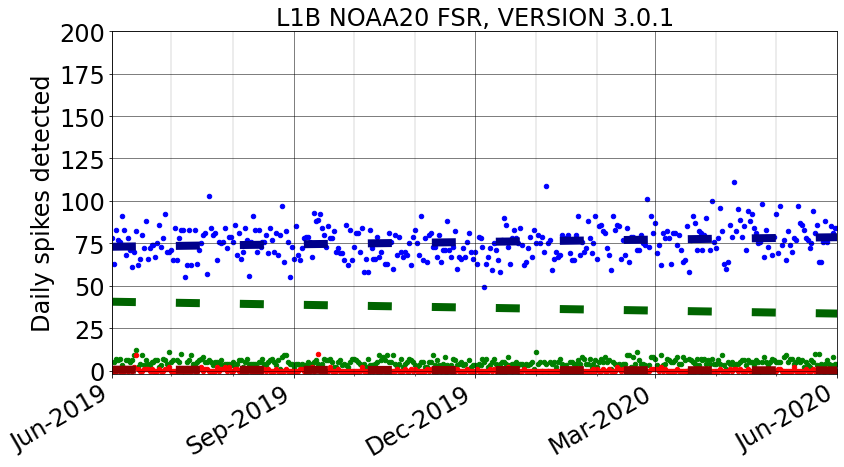

In [33]:
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')

################################################
# matplotlib uses x=0 as 1970. Survey uses 2010.
offset = (base_date - datetime(1970, 1, 1)).days
adjusted_x = x + offset
################################################

# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(13, 7))
# Plot all 3 x and y with dots of size 20.
for y, color in [(sw_y, 'blue'),
                 (mw_y, 'green'),
                 (lw_y, 'red')]:
    ###############################################################
    ax.scatter(adjusted_x, y, color=color, s=20)
    
    m, b = np.polyfit(adjusted_x, y, 1)
    plt.plot(adjusted_x, m * (adjusted_x) + b, '--', dashes=(3, 5),
             linewidth=8, color='dark' + color)
    ###############################################################

# Add the survey info to the title.
ax.set_title('{0} {1} {2}, VERSION {3}'.format(survey.product,
                                               survey.instrument,
                                               survey.resolution,
                                               survey.software_version))
ax.set_ylabel('Daily spikes detected')

text_objects = [ax.title, ax.xaxis.label, ax.yaxis.label]
text_objects.extend(ax.get_xticklabels())
text_objects.extend(ax.get_yticklabels())
for text_object in (text_objects):
    text_object.set_fontsize(24)

ax.set_ylim([-2, 200])

###########################################################
# Make a label every 3 months.
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Make grid lines every month.
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
# Color the grid.
ax.grid(which='minor', linewidth=.15, color='black')
ax.grid(which='major', linewidth=.5, color='black')
# Make the label name the abreviated month and year.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Bound our x-axis to our dates.
ax.set_xlim(adjusted_x[0], adjusted_x[-1])
# Make the date labels look pretty!
fig.autofmt_xdate()
###########################################################

fig.show()

### Add a legend

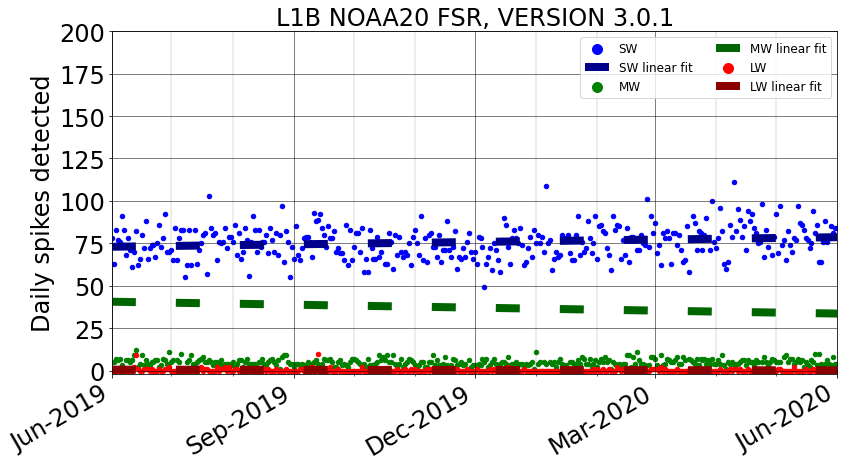

In [46]:
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')

####################################################################
legend = {}
####################################################################

# matplotlib uses x=0 as 1970. Survey uses 2010.
offset = (base_date - datetime(1970, 1, 1)).days
adjusted_x = x + offset

# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(13, 7))
# Plot all 3 x and y with dots of size 20.
for y, color, plot_name, fit_name in [(sw_y, 'blue', 'SW', 'SW linear fit'),
                 (mw_y, 'green', 'MW', 'MW linear fit'),
                 (lw_y, 'red', 'LW', 'LW linear fit')]:
    ##################################################################################
    legend[plot_name] = ax.scatter(adjusted_x, y, color=color, s=20)
    
    m, b = np.polyfit(adjusted_x, y, 1)
    legend[fit_name] = plt.plot(adjusted_x, m * (adjusted_x) + b, '--', dashes=(3, 5),
                                linewidth=8, color='dark' + color)[0]
    ##################################################################################

# Add the survey info to the title.
ax.set_title('{0} {1} {2}, VERSION {3}'.format(survey.product,
                                               survey.instrument,
                                               survey.resolution,
                                               survey.software_version))
ax.set_ylabel('Daily spikes detected')

text_objects = [ax.title, ax.xaxis.label, ax.yaxis.label]
text_objects.extend(ax.get_xticklabels())
text_objects.extend(ax.get_yticklabels())
for text_object in (text_objects):
    text_object.set_fontsize(24)

ax.set_ylim([-2, 200])

# Make a label every 3 months.
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Make grid lines every month.
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
# Color the grid.
ax.grid(which='minor', linewidth=.15, color='black')
ax.grid(which='major', linewidth=.5, color='black')
# Make the label name the abreviated month and year.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
# Bound our x-axis to our dates.
ax.set_xlim(adjusted_x[0], adjusted_x[-1])
# Make the date labels look pretty!
fig.autofmt_xdate()

####################################################################
leg = ax.legend(legend.values(), legend.keys(), ncol=2, fontsize=12)
leg.legendHandles[0].set_sizes([100])
leg.legendHandles[2].set_sizes([100])
leg.legendHandles[4].set_sizes([100])
####################################################################

fig.show()

In [196]:
%matplotlib widget
#%matplotlib inline
# Close all plots. Prevents memory problems if running multiple times.
plt.close('all')
# Get the figure and axis objects.
fig, ax = plt.subplots(figsize=(8, 5))
# Plot x and sw_y with dots of size 20 and color blue.
coll = ax.scatter(x, sw_y, color='blue', s=20, picker=1)

# Set the y-axis from 0 to 200.
ax.set_ylim([0, 200])
ax.set_xlim([x[0], x[-1]])

output = widgets.Label(value='')
def on_pick(event):
    output.value = 'days clicked: {}'.format(x[event.ind])

fig.canvas.mpl_connect('pick_event', on_pick)

fig.show()
display(output)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Label(value='')